# Train DECiSION incl. data augmentation

## Set seeds and import packages

In [1]:
RANDOM_STATE = 42
from numpy.random import seed
seed(RANDOM_STATE)

from tensorflow import set_random_seed
set_random_seed(RANDOM_STATE)

import random
random.seed = RANDOM_STATE

import DECiSION_settings as settings

from dltoolkit.utils.generic import model_architecture_to_file, model_summary_to_file, list_images
from dltoolkit.nn.segment import UNet_NN
from dltoolkit.utils.visual import plot_training_history
from dltoolkit.iomisc import HDF5Generator_Segment

from thesis_common import convert_img_to_pred, convert_pred_to_img, create_hdf5_db,\
    show_image, read_preprocess_image, read_preprocess_groundtruth
from thesis_metric_loss import dice_coef, weighted_pixelwise_crossentropy_loss

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import numpy as np
import os, cv2, time, progressbar

import matplotlib.pyplot as plt
%matplotlib inline

/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Convert training set to HDF5

In [2]:
def perform_hdf5_conversion(settings):
    # Prepare the path to the training images and ground truths
    img_exts = ".jpg"
    img_path = os.path.join(settings.TRAINING_PATH, settings.FLDR_IMAGES)
    msk_path = os.path.join(settings.TRAINING_PATH, settings.FLDR_GROUND_TRUTH)

    # Create a list of paths to the individual patient folders
    patient_fld_imgs = sorted([os.path.join(img_path, e.name) for e in os.scandir(img_path) if e.is_dir()])
    patient_fld_masks = sorted([os.path.join(msk_path, e.name) for e in os.scandir(msk_path) if e.is_dir()])

    # Obtain a list of paths to the training images and ground truths for each patient
    img_list = []
    msk_list = []
    for patient_ix, (p_fld_imgs, p_fld_masks) in enumerate(zip(patient_fld_imgs, patient_fld_masks)):
        img_list.extend(sorted(list(list_images(basePath=p_fld_imgs,
                                                validExts=img_exts)))
                        [settings.SLICE_START:settings.SLICE_END])
        msk_list.extend(sorted(list(list_images(basePath=p_fld_masks,
                                                validExts=img_exts)))
                        [settings.SLICE_START:settings.SLICE_END])

    assert(len(img_list) == len(msk_list))

    # Split the training set into a training and validation set
    train_img, val_img, train_msk, val_msk = train_test_split(img_list, msk_list,
                                                              test_size=settings.TRN_TRAIN_VAL_SPLIT,
                                                              random_state=settings.RANDOM_STATE,
                                                              shuffle=True)
    
    # Create the HDF5 data sets
    output_paths = []

    # Training images
    output_paths.append(create_hdf5_db(train_img, "train", img_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings))

    # Training ground truths
    output_paths.append(create_hdf5_db(train_msk, "train", msk_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings,
                                       is_mask=True))

    # Validation images
    output_paths.append(create_hdf5_db(val_img, "val", img_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings))

    # Validation ground truths
    output_paths.append(create_hdf5_db(val_msk, "val", msk_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings,
                                       is_mask=True))

    return output_paths

In [3]:
# Convert image files to HDF5
if settings.IS_DEVELOPMENT:
    print("\n--- Converting images to HDF5")
    hdf5_paths = perform_hdf5_conversion(settings)
else:
    # During development avoid performing HDF5 conversion for every run
    hdf5_paths = ["../data/MSC8002/training/train_imgs.h5",
                  "../data/MSC8002/training/train_masks.h5",
                  "../data/MSC8002/training/val_imgs.h5",
                  "../data/MSC8002/training/val_masks.h5"
                  ]

Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00



--- Converting images to HDF5
../data/MSC8002/training/train_imgs.h5
../data/MSC8002/training/train_masks.h5
../data/MSC8002/training/val_imgs.h5
../data/MSC8002/training/val_masks.h5


## Class distribution

In [4]:
# Print class distribution
class_weights = [settings.CLASS_WEIGHT_BACKGROUND, settings.CLASS_WEIGHT_BLOODVESSEL]
print("Class distribution: {}".format(class_weights))

Class distribution: [1.0, 10.0]


## Create U-Net model

In [5]:
# Instantiate the U-Net model
unet = UNet_NN(img_height=settings.IMG_HEIGHT,
               img_width=settings.IMG_WIDTH,
               img_channels=settings.IMG_CHANNELS,
               num_classes=settings.NUM_CLASSES)

# model = unet.build_model_sigmoid()
# model = unet.build_model_flatten()
model = unet.build_model_softmax()

## Create paths

In [6]:
# Prepare some path strings
model_path = os.path.join(settings.MODEL_PATH, "DECiSION_" + unet.title + "_ep{}.model".format(settings.TRN_NUM_EPOCH))
summ_path = os.path.join(settings.OUTPUT_PATH, "DECiSION_" + unet.title + "_model_summary.txt")
csv_path = os.path.join(settings.OUTPUT_PATH, "DECiSION_" + unet.title + "_training_ep{}_bs{}.csv".format(settings.TRN_NUM_EPOCH,
                                                                                            settings.TRN_BATCH_SIZE))

## Save/print model architecture information

In [7]:
# Print the architecture to the console, a text file and an image
model.summary()
model_summary_to_file(model, summ_path)
model_architecture_to_file(unet.model, settings.OUTPUT_PATH + "DECiSION_" + unet.title)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 120, 120, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

## Compile the model

In [8]:
# Set the optimiser, loss function and metrics
opt = Adam()
metrics = [dice_coef]
loss = weighted_pixelwise_crossentropy_loss(class_weights)

# Compile
model.compile(optimizer=opt, loss=loss, metrics=metrics)

## Prepare data generators

In [9]:
# Training set generator using data augmentation
rdr_train = HDF5Generator_Segment(hdf5_paths[0], hdf5_paths[1],
                                  batch_size=settings.TRN_BATCH_SIZE,
                                  num_classes=settings.NUM_CLASSES,
                                  converter=convert_img_to_pred, 
#                                   data_gen_args=data_gen_args,
                                  feat_key=settings.HDF5_KEY)
gen_train = rdr_train.generator(num_epochs=settings.TRN_NUM_EPOCH)

# Validation set generator (does NOT use data augmentation)
rdr_val = HDF5Generator_Segment(hdf5_paths[2], hdf5_paths[3],
                                batch_size=settings.TRN_BATCH_SIZE,
                                num_classes=settings.NUM_CLASSES,
                                converter=convert_img_to_pred, 
                                feat_key=settings.HDF5_KEY)
gen_val = rdr_val.generator(num_epochs=settings.TRN_NUM_EPOCH)

print(" num trn samples: {}".format(rdr_train.num_images()))
print(" num val samples: {}".format(rdr_val.num_images()))

print(" steps_per_epoch: {}".format(rdr_train.num_images()/settings.TRN_BATCH_SIZE))
print("validation_steps: {}".format(rdr_val.num_images()/settings.TRN_BATCH_SIZE))

 num trn samples: 9
 num val samples: 1
 steps_per_epoch: 9.0
validation_steps: 1.0


## Train WITH a validation set

In [10]:
# Prepare callbacks
callbacks = [ModelCheckpoint(model_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1),
             EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=settings.TRN_EARLY_PATIENCE,
                           verbose=0,
                           mode="auto"),
             CSVLogger(csv_path, append=False),
             ]

# Fit the model using generators and a validation set
start_time = time.time()
hist = model.fit_generator(gen_train,
                 epochs=settings.TRN_NUM_EPOCH,
                 steps_per_epoch=rdr_train.num_images()/settings.TRN_BATCH_SIZE,
                 verbose=2,
                 validation_data=gen_val,
                 validation_steps=rdr_val.num_images()/settings.TRN_BATCH_SIZE,
                 shuffle=True,
                 callbacks=callbacks)

print("\n\nElapsed training time: {} min".format(int((time.time() - start_time))/60))

Epoch 1/100
 - 6s - loss: 34602.6914 - dice_coef: 0.6743 - val_loss: 18649.3320 - val_dice_coef: 0.8967

Epoch 00001: val_loss improved from inf to 18649.33203, saving model to ../savedmodels/DECiSION_UNet_brain_softmax_ep100.model
Epoch 2/100
 - 5s - loss: 19205.3371 - dice_coef: 0.8590 - val_loss: 20503.1797 - val_dice_coef: 0.9491

Epoch 00002: val_loss did not improve
Epoch 3/100
 - 5s - loss: 16885.0245 - dice_coef: 0.8938 - val_loss: 19081.3164 - val_dice_coef: 0.9414

Epoch 00003: val_loss did not improve
Epoch 4/100
 - 6s - loss: 15634.9128 - dice_coef: 0.9228 - val_loss: 17140.0078 - val_dice_coef: 0.9163

Epoch 00004: val_loss improved from 18649.33203 to 17140.00781, saving model to ../savedmodels/DECiSION_UNet_brain_softmax_ep100.model
Epoch 5/100
 - 6s - loss: 14638.4697 - dice_coef: 0.9230 - val_loss: 15817.2734 - val_dice_coef: 0.9159

Epoch 00005: val_loss improved from 17140.00781 to 15817.27344, saving model to ../savedmodels/DECiSION_UNet_brain_softmax_ep100.model
Ep


Epoch 00044: val_loss did not improve
Epoch 45/100
 - 8s - loss: 1096.5199 - dice_coef: 0.9935 - val_loss: 1726.0284 - val_dice_coef: 0.9920

Epoch 00045: val_loss did not improve
Epoch 46/100
 - 7s - loss: 1043.9600 - dice_coef: 0.9945 - val_loss: 1760.1234 - val_dice_coef: 0.9906

Epoch 00046: val_loss did not improve
Epoch 47/100
 - 7s - loss: 997.0122 - dice_coef: 0.9939 - val_loss: 1953.0547 - val_dice_coef: 0.9933

Epoch 00047: val_loss did not improve
Epoch 48/100
 - 7s - loss: 898.0057 - dice_coef: 0.9950 - val_loss: 1805.2021 - val_dice_coef: 0.9921

Epoch 00048: val_loss did not improve


Elapsed training time: 6.683333333333334 min


## Train WITHOUT a validation set

## Plot the results

In [11]:
plot_training_history(hist,
                      settings.TRN_NUM_EPOCH,
                      show=False,
                      save_path=settings.OUTPUT_PATH + unet.title,
                      time_stamp=True,
                      metric="dice_coef")

## Perform pipeline test

Loading image HDF5: ../data/MSC8002/training/train_imgs.h5 with dtype = float32

Loading ground truth HDF5: ../data/MSC8002/training/train_masks.h5 with dtype = uint8

Elapsed time: 0.003952741622924805


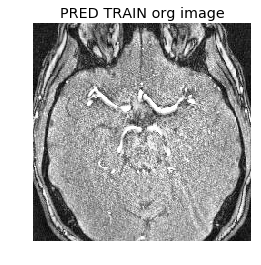

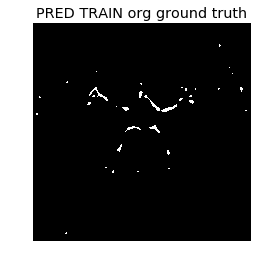

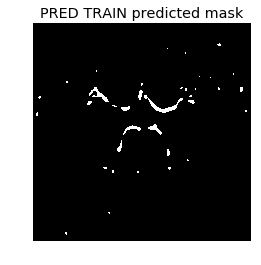

  original 1.0 dtype float32
  gr truth 255 dtype uint8
prediction 255 dtype float32


In [12]:
# Read images and ground truths
train_imgs = read_preprocess_image(hdf5_paths[0], settings.HDF5_KEY)
train_grndtr = read_preprocess_groundtruth(hdf5_paths[1], settings.HDF5_KEY)

# For pipeline testing only, predict on one training image
predictions = model.predict(train_imgs, batch_size=settings.TRN_BATCH_SIZE, verbose=2)

# predictions = predictions
# predictions = convert_pred_to_img_flatten(predictions, settings.TRN_PRED_THRESHOLD)
predictions_conv = convert_pred_to_img(predictions, settings.TRN_PRED_THRESHOLD)


show_image(np.squeeze(train_imgs[0]), 'PRED TRAIN org image')
show_image(np.squeeze(train_grndtr[0]), 'PRED TRAIN org ground truth')
show_image(np.squeeze(predictions_conv[0]), 'PRED TRAIN predicted mask')

print("  original {} dtype {}".format(np.max(train_imgs[0]), train_imgs[0].dtype))
print("  gr truth {} dtype {}".format(np.max(train_grndtr[0]), train_grndtr[0].dtype))
print("prediction {} dtype {}".format(np.max(predictions_conv[0]), predictions[0].dtype))